# Validation: Forecasting Held-Out Data

This notebook:

* loads a library defined model. 
* loads the data according to the data loader.
* holds-out the final few days of the data, and see's if they can be predicted. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
### Initial imports
import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from epimodel.pymc3_models.utils import geom_convolution
from epimodel.pymc3_models import cm_effect

%matplotlib inline

In [3]:
Regions = ["PT", "IS", "HU", "HR", "BE", "NL", "DK", "DE", "AT", "CZ", "GE", "FR", "ES", "GB", "PL", "GR", "CH", "FI", "NO", "SE", "SI", "SK"]
Features = ['Gatherings limited to', 'Business suspended',
       'Schools and universities closed', 'General curfew',
       'Healthcare specialisation', 'Minor distancing and hygiene measures',
       'Phone line', 'Mask wearing', 'Asymptomatic contact isolation']
data = cm_effect.loader.Loader('2020-02-10', '2020-04-05', Regions, Features)

# Probability of being in Confirmed cases X days after transmission, from 0
# Generated from Poisson dist., must sum to 1.0
DelayProb = np.array([0.00, 0.01, 0.02, 0.06, 0.10, 0.13, 0.15, 0.15, 0.13, 0.10, 0.07, 0.05, 0.03])
print(f"Delayprob sum={DelayProb.sum()}, E[DP]={np.sum(DelayProb*np.arange(len(DelayProb)))}")

INFO:epimodel.regions:Name index has 6 potential conflicts: ['american samoa', 'georgia', 'guam', 'northern mariana islands', 'puerto rico', 'united states minor outlying islands']
INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Delayprob sum=1.0, E[DP]=6.78


In [6]:
# note that this model should be the exact same as in the jupyter notebook, but the testpoint
# isn't the same. I'm not quite sure why, and am unaware if its an issue. 
with cm_effect.models.CMModelV2(data) as model:
    model.build_all()

/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in Observed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
INFO:epimodel.pymc3_models.cm_effect.models:Checking model test point
INFO:epimodel.pymc3_models.cm_effect.models:
CMReduction_log__            12.45
BaseGrowthRate_log__         -1.61
RegionGrowthRate_log__        6.27
RegionScaleMult_log__       -20.22
DailyGrowth_log__          1400.25
InitialSize_log__           -70.87
Observed_missing              0.00
Observed                 -15098.43
Name: Log-probability of test_point, dtype: float64



In [5]:
model.run(1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...


CMReduction_log__            12.45
BaseGrowthRate_log__         -1.61
RegionGrowthRate_log__        6.27
RegionScaleMult_log__       -20.22
DailyGrowth_log__          1400.25
InitialSize_log__           -70.87
Observed_missing              0.00
Observed                 -15098.43
Name: Log-probability of test_point, dtype: float64


Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Observed_missing, InitialSize, DailyGrowth, RegionScaleMult, RegionGrowthRate, BaseGrowthRate, CMReduction]
INFO:pymc3:NUTS: [Observed_missing, InitialSize, DailyGrowth, RegionScaleMult, RegionGrowthRate, BaseGrowthRate, CMReduction]
Sampling 2 chains, 0 divergences:   7%|▋         | 206/3000 [00:02<00:40, 69.55draws/s] 


RuntimeError: Chain 1 failed.

INFO:epimodel.regions:Name index has 6 potential conflicts: ['american samoa', 'georgia', 'guam', 'northern mariana islands', 'puerto rico', 'united states minor outlying islands']



CMS countermeasures-features.csv columns:
Index(['Symptomatic isolation - targeted', 'Symptomatic isolation - blanket',
       'Asymptomatic isolation - targeted', 'Asymptomatic isolation - blanket',
       'Domestic travel restriction', 'Nonessential business suspension',
       'International travel restriction', 'Testing', 'Contact tracing',
       'Mask wearing', 'Hand washing', 'Gatherings banned',
       'Healthcare specialisation', 'Public education and incentives',
       'Assisting people to stay home', 'Public cleaning',
       'Miscellaneous hygiene measures', 'Public interaction and hygiene',
       'School closure', 'Activity cancellation', 'Resumption',
       'Diagnostic criteria loosened', 'Diagnostic criteria tightened',
       'Testing criteria'],
      dtype='object')

CMS countermeasures-model-0to1.csv columns:
Index(['Gatherings limited to', 'Business suspended',
       'Schools and universities closed', 'General curfew',
       'Healthcare specialisation', 'Minor

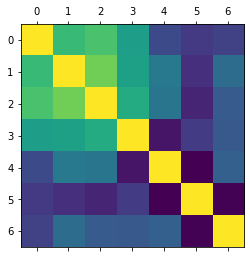

In [15]:
from pathlib import Path
import theano 
DATA_DIR = Path("../../data")

### Import epimodel and load relevant files
from epimodel import RegionDataset, read_csv

from epimodel.regions import Level

rds = RegionDataset.load(DATA_DIR / 'regions.csv')
csse = read_csv(DATA_DIR / 'johns-hopkins.csv')

CMSS = ['countermeasures-features.csv', 'countermeasures-model-0to1.csv', 'countermeasures-selected-binary.csv']
cm_sets = {n: read_csv(DATA_DIR / n) for n in CMSS}
for n, v in cm_sets.items():
    print(f"\nCMS {n} columns:\n{v.columns!r}")
    
### Parameters and data loading

# Days
Ds = pd.date_range(start='2020-02-10', end='2020-04-05', tz='utc')
nDs = len(Ds)

# Countermeasures
CMS = cm_sets['countermeasures-model-0to1.csv']

# CMS-01 columns
CMs = ['Gatherings limited to', 'Business suspended', 'Schools and universities closed', 'General curfew',
       'Healthcare specialisation', 'Phone line',
       'Asymptomatic contact isolation'] #  'Mask wearing', 'Minor distancing and hygiene measures',]
# Selected CMS-b columns
#CMs = ["Contact isolation", "Some businesses suspended", "Many businesses suspended",
#       "Schools and universities closed", "Social distancing advised", "Gatherings limited to 10 or less",
#       "General curfew", "General strict isolation"]
nCMs = len(CMs)

# Countries (or just any regions)
#Cs0 = ["BG", "UA", "PT", "IS", "RO", "HU", "IT", "HR", "BE", "NL", "DK", "DE", "AT", "CZ", "GE", "FR", "ES", "GB", "PL", "GR", "CH", "BE", "FI", "HU", "NO", "RO", "SE", "SI", "SK"]
Cs0 = ["PT", "IS", "HU", "HR", "BE", "NL", "DK", "DE", "AT", "CZ", "GE", "FR", "ES", "GB", "PL", "GR", "CH", "BE", "FI", "NO", "SE", "SI", "SK"]
Cs = []
# Filtering just countries with JH data, countermeasures data and at least 100 cases
for cc in set(Cs0):
    print(cc)
    c = rds[cc]
    if c.Level == Level.country:
        if c.Code in csse.index and c.Code in CMS.index:
            if csse.loc[(c.Code, Ds[-1]), "Active"] > 100:
                Cs.append(c.Code)
nCs = len(Cs)
print(f"\n{nCs} countries selected: {Cs!r}\n")

# Probability of being in Confirmed cases X days after transmission, from 0
# Generated from Poisson dist., must sum to 1.0
DelayProb = np.array([0.00, 0.01, 0.02, 0.06, 0.10, 0.13, 0.15, 0.15, 0.13, 0.10, 0.07, 0.05, 0.03])
print(f"Delayprob sum={DelayProb.sum()}, E[DP]={np.sum(DelayProb*np.arange(len(DelayProb)))}")

# Active countermeasures per day and region
print("\nCountermeasures                               min   .. mean  .. max")
sd = CMS.loc[Cs, CMs]
if 'Mask wearing' in CMs:
    sd['Mask wearing'] *= 0.01
for i, cm in enumerate(CMs):
    print(f"{i:2} {cm:42} {sd[cm].min().min():.3f} .. {sd[cm].mean().mean():.3f} .. {sd[cm].max().max():.3f}")
ActiveCMs = np.stack([sd.loc[c].loc[Ds].T for c in Cs])
assert ActiveCMs.shape == (nCs, nCMs, nDs)
# [country, CM, day] Which CMs are active, and to what extent
ActiveCMs = ActiveCMs.astype(theano.config.floatX)

plt.matshow(sd.corr())
plt.show()

# Confirmed cases, masking values smaller than 10
Confirmed = csse["Confirmed"].loc[(tuple(Cs), Ds)].unstack(1).values
assert Confirmed.shape == (nCs, nDs)
Confirmed[Confirmed < 10.0] = np.nan
# [country, day]
Confirmed = np.ma.masked_invalid(Confirmed.astype(theano.config.floatX))

# Active cases, masking values smaller than 10
Active = csse["Active"].loc[(tuple(Cs), Ds)].unstack(1).values
assert Active.shape == (nCs, nDs)
Active[Active < 10.0] = np.nan
# [country, day]
Active = np.ma.masked_invalid(Active.astype(theano.config.floatX))

In [20]:
with pm.Model() as model2:
    CMDelayCut = 10
    # [] Baseline growth rate (wide prior OK, mean estimates ~10% daily growth)
    BaseGrowthRate = pm.Lognormal("BaseGrowthRate", np.log(1.2), 2.0)
    
    # [country] Initial size of epidemic (the day before the start, only those detected; wide prior OK)
    InitialSize = pm.Lognormal("InitialSize", 0.0, 10, shape=(nCs,))
    
    # [country] Country growth rate
    # TODO: Estimate growth rate variance
    CountryGrowthRate = pm.Lognormal("CountryGrowthRate", pm.math.log(BaseGrowthRate), 0.3, shape=(nCs,))

    # [country] Country unreliability as common scale multiplier of its:
    # * measurements (measurement unreliability)
    # * expected growth noise
    # TODO: Estimate good prior (but can be weak?)
    CountryScaleMult = pm.Lognormal("CountryScaleMult", 0.0, 1.0, shape=(nCs,)) # Weak prior!
    
    # [CM] How much countermeasures reduce growth rate
    # TODO: Possibly use another distribution
    CMReduction = pm.Lognormal("CMReduction", 0.0, 0.1, shape=(nCMs,))
    
    # [country, CM, day] Reduction factor for each CM,C,D
    ActiveCMReduction = T.reshape(CMReduction, (1, nCMs, 1)) ** ActiveCMs
    
    # [country, day] Reduction factor from CMs for each C,D (noise added below)
    GrowthReduction = pm.Deterministic("GrowthReduction", T.prod(ActiveCMReduction, axis=1))

    # [country, day] Convolution of GrowthReduction by DelayProb along days
    DelayedGrowthReduction = geom_convolution(GrowthReduction, DelayProb, axis=1)

    # Erase early DlayedGrowthRates in first ~10 days (would assume them non-present otherwise!)
    DelayedGrowthReduction = DelayedGrowthReduction[:, CMDelayCut:]
    
    # [country, day - CMDelayCut] The ideal predicted daily growth
    PreictedGrowth = pm.Deterministic("PredictedGrowth",                          
        T.reshape(CountryGrowthRate, (nCs, 1)) * DelayedGrowthReduction)
    
    # [country, day - CMDelayCut] The actual (still hidden) growth rate each day
    # TODO: Estimate noise varince (should be small, measurement variance below)
    #       Miscalibration: too low: time effects pushed into CMs, too high: explains away CMs
    DailyGrowth =  pm.Lognormal("DailyGrowth",
                                pm.math.log(PreictedGrowth), 
                                CountryScaleMult.reshape((nCs, 1)) * 0.1, shape=(nCs, nDs - CMDelayCut))

    # Below I assume plain exponentia growth of confirmed rather than e.g. depending on the remaining
    # susceptible opulation etc.

    #AdditiveDailyGrowth = DailyGrowth
    # [country, day - CMDelayCut] The number of cases that would be detected with noiseless testing
    # (Noise source includes both false-P/N rates and local variance in test volume and targetting)
    # (Since we ony care about growth rates and assume consistent testing, it is fine to ignore real size)
    Size = pm.Deterministic("Size", T.reshape(InitialSize, (nCs, 1)) * DailyGrowth.cumprod(axis=1))

    # [country, day - CMDelayCut] Cummulative tested positives
    Observed = pm.Lognormal("Observed",
                            pm.math.log(Size), CountryScaleMult.reshape((nCs, 1)) * 0.4,
                            shape=(nCs, nDs - CMDelayCut),
                            observed=Confirmed[:, CMDelayCut:])

/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in Observed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [22]:
print(model.check_test_point())
with model:
    trace = pm.sample(2000, chains=2, cores=2, init='adapt_diag')

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...


CMReduction_log__            12.45
BaseGrowthRate_log__         -1.61
RegionGrowthRate_log__        6.27
RegionScaleMult_log__       -20.22
DailyGrowth_log__          1400.25
InitialSize_log__           -70.87
Observed_missing              0.00
Observed                 -15098.43
Name: Log-probability of test_point, dtype: float64


Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Observed_missing, InitialSize, DailyGrowth, RegionScaleMult, RegionGrowthRate, BaseGrowthRate, CMReduction]
INFO:pymc3:NUTS: [Observed_missing, InitialSize, DailyGrowth, RegionScaleMult, RegionGrowthRate, BaseGrowthRate, CMReduction]
Sampling 2 chains, 0 divergences:   4%|▍         | 206/5000 [00:02<01:08, 69.50draws/s] 


RuntimeError: Chain 0 failed.

In [24]:
Confirmed[:, CMDelayCut:]

masked_array(
  data=[[--, --, --, ..., 11524.0, 11781.0, 12051.0],
        [--, --, --, ..., 16770.0, 18431.0, 19691.0],
        [--, --, --, ..., 19606.0, 20505.0, 21100.0],
        ...,
        [--, --, --, ..., 6131.0, 6443.0, 6830.0],
        [--, --, --, ..., 934.0, 977.0, 997.0],
        [--, --, --, ..., 450.0, 471.0, 485.0]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=1e+20)